# Batching

Tradeoff: Throughput vs Latency
- Batching: At the cost of some latency we can utilize the resources at max capacity
- Untill x number of request come or until some time pass we do not execute the batch of requests
- The requests can be of different lengths: We add padding to them to make them equal length
- padding can be added to left or right. Left while doing inference as you do not want [pad] [pad] in text sequence otherwise

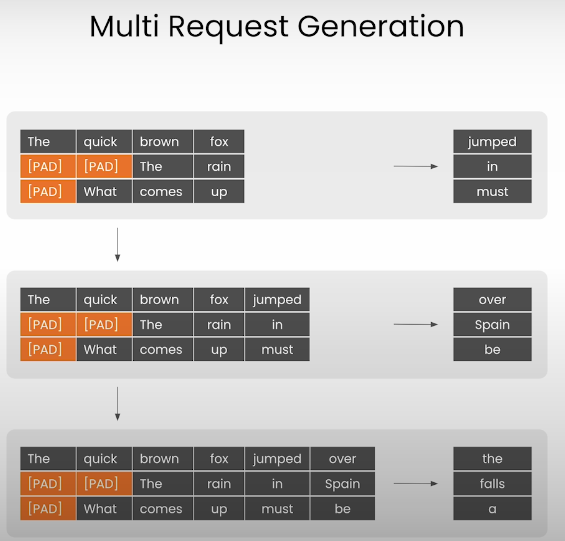

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [3]:
model_name = "gpt2"
# model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

### Reuse same KV-Cache text generation

In [4]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [5]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)

In [6]:
tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


#### Test

In [20]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [21]:
tokenizer.decode(464)

'The'

In [22]:
## Considering all inputs (without KV caching)
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
tokenizer.decode(next_token_id)

' fence'

In [27]:
next_token_id, next_token_id.shape, next_token_id.reshape(1,1)

(tensor(13990), torch.Size([]), tensor([[13990]]))

In [32]:
torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    )

tensor([[1, 1, 1, 1, 1, 1, 1, 1]])

In [41]:
len(outputs.past_key_values), len(outputs.past_key_values[0])

(12, 2)

In [42]:
outputs.past_key_values[0][0].shape, outputs.past_key_values[1][0].shape

(torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]))

In [44]:
## With KV Caching only passing last token and past key values 
next_inputs = {
    "input_ids": next_token_id.reshape((1, 1)),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
    "past_key_values": outputs.past_key_values,
}

with torch.no_grad():
    outputs = model(**next_inputs)
logits = outputs.logits
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()

In [45]:
tokenizer.decode(next_token_id)

' and'

In [47]:
outputs.past_key_values[0][0].shape, outputs.past_key_values[1][0].shape ## 8 for 8 previous tokens

(torch.Size([1, 12, 8, 64]), torch.Size([1, 12, 8, 64]))

#### testing with diff attention

In [67]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [68]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
tokenizer.decode(next_token_id)

' fence'

In [69]:
next_inputs = {
    "input_ids": next_token_id.reshape((1, 1)),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
    "past_key_values": outputs.past_key_values,
}

next_inputs1 = {
    "input_ids": next_token_id.reshape((1, 1)),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[0]])],
        dim=1
    ),
    "past_key_values": outputs.past_key_values,
}

with torch.no_grad():
    outputs = model(**next_inputs)
    outputs1 = model(**next_inputs1)

logits = outputs.logits
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()

logits1 = outputs1.logits
last_logits1 = logits1[0, -1, :]
next_token_id1 = last_logits1.argmax()

tokenizer.decode(next_token_id), tokenizer.decode(next_token_id1)

(' and', ' and')

## Padding and Batching

In [70]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
tokenizer.pad_token, model.config.pad_token_id

('<|endoftext|>', 50256)

In [71]:
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

- Tokenize list of prompts
- Add padding so that all prompts have the same number of tokens as the longest prompt


In [72]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])}

- Add position ids to track original order of tokens in each prompt
- Padding tokens are set to 1 and then first real token starts with position 0

In [73]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [74]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [75]:
last_logits = logits[:, -1, :]  ## all promots, last values, all tokens
next_token_ids = last_logits.argmax(dim=1) 

In [76]:
print(next_token_ids)
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

tensor([13990,   319,   307])


[' fence', ' on', ' be']

In [89]:
print(attention_mask)
print(attention_mask == 0)
print(attention_mask.long().cumsum(-1) - 1)
(attention_mask.long().cumsum(-1) - 1).masked_fill_(attention_mask == 0, 1)

tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
tensor([[False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False]])
tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [-1, -1,  0,  1,  2,  3,  4],
        [-1, -1, -1,  0,  1,  2,  3]])


tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

### Test
 - Generate n tokens with past


In [90]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

## Generate all tokens for some max tokens

def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

# Call the generate_batch function and print out the generated tokens

generated_tokens = generate_batch(inputs, max_tokens=10)

for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



## Throughput vs Latency
Explore the effect of batching on latency (how long it takes to generate each token).
Observe the fundamental tradeoff that exists between throughput and latency. First image is a system optimized for latency and second is optimized for Throughput.

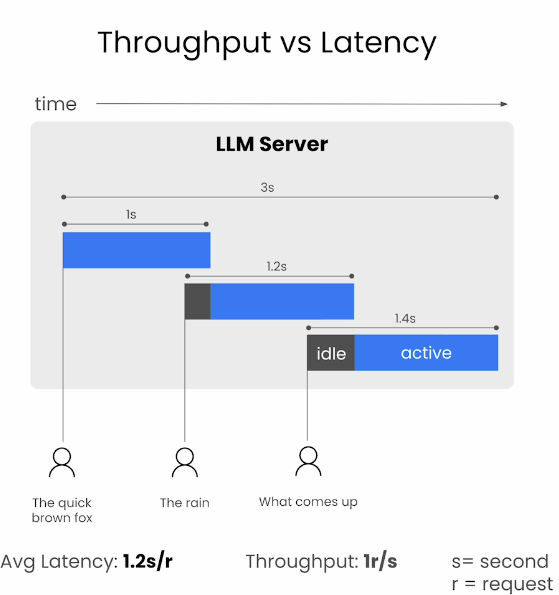
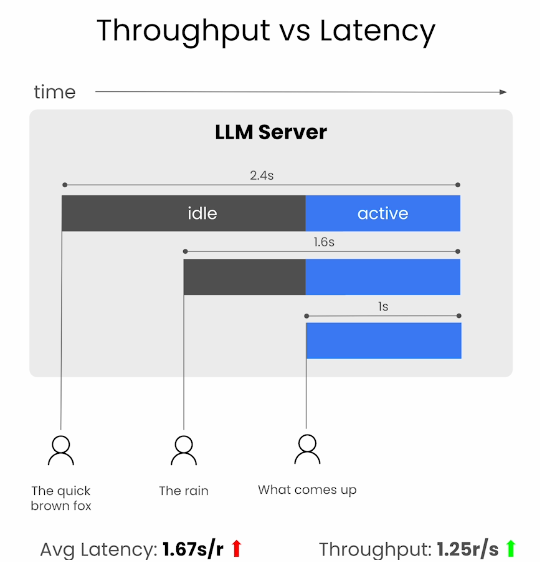

In [91]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s # how many tokens per second
    avg_latency = duration_s / max_tokens # for each token how much time it took
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.4686439037322998
throughput 21.338162985498325
avg latency 0.04686439037322998

bs= 2
duration 0.5247542858123779
throughput 38.11307604479643
avg latency 0.05247542858123779

bs= 4
duration 0.588054895401001
throughput 68.02086048909356
avg latency 0.0588054895401001

bs= 8
duration 0.6540021896362305
throughput 122.32374947322066
avg latency 0.06540021896362305

bs= 16
duration 0.8410158157348633
throughput 190.24612499135358
avg latency 0.08410158157348632

bs= 32
duration 1.1422779560089111
throughput 280.1419727279615
avg latency 0.11422779560089111

bs= 64
duration 2.216399669647217
throughput 288.75658517936364
avg latency 0.22163996696472169

bs= 128
duration 3.6487631797790527
throughput 350.80380307869393
avg latency 0.36487631797790526



In [92]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

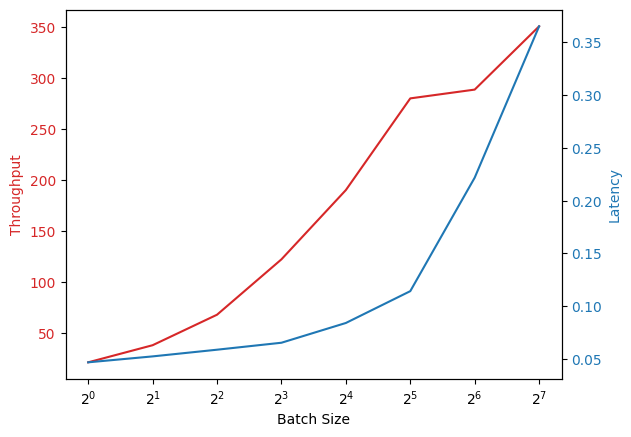

In [93]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

With batch size thorughput increases but latency also increases so need to find a balance between them based on the application.